In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
tf.set_random_seed(777)

In [4]:
f_name = 'bitcoin.csv'
encoding = 'euc-kr'
names = ['date','open','high','low','close','volume']
df = pd.read_csv(f_name, names=names, encoding=encoding)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1624 entries, 0 to 1623
Data columns (total 6 columns):
date      1624 non-null object
open      1624 non-null object
high      1624 non-null object
low       1624 non-null object
close     1624 non-null object
volume    1624 non-null object
dtypes: object(6)
memory usage: 76.2+ KB


In [5]:
del df['date']

In [6]:
coin_float = df.values[1:].astype(np.float)

In [7]:
print(coin_float.shape)
print(coin_float[0])

(1623, 5)
[7.63280e+02 7.77510e+02 7.13600e+02 7.35070e+02 4.68627e+07]


In [8]:
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7)

In [9]:
index = coin_float[:,:-1]
norm_index = min_max_scaling(index)

In [10]:
print(index.shape)
print(index[0])
print(norm_index[0])

(1623, 4)
[763.28 777.51 713.6  735.07]
[0.02971107 0.03042552 0.02721678 0.02829473]


In [11]:
volume = coin_float[:,-1:]
norm_volume = min_max_scaling(volume)

In [12]:
print(volume.shape)
print(volume[500])
print(norm_volume[500])

(1623, 1)
[20892300.]
[0.00075654]


In [13]:
x = np.concatenate((norm_index, norm_volume), axis=1)

In [14]:
print(x.shape)
print(x[-1])

(1623, 5)
[0.37426704 0.37700132 0.36804336 0.37567334 0.19671927]


In [15]:
y = x[:, [-2]]

In [16]:
print(y.shape)
print(y[0])
print(y[-1])

(1623, 1)
[0.02829473]
[0.37567334]


In [17]:
dataX = []
dataY = []

In [18]:
seq_length = 28
for i in range(0, len(y) - seq_length):
    _x = x[i: i + seq_length]
    _y = y[i + seq_length]
    dataX.append(_x)
    dataY.append(_y)

In [19]:
print(dataX[0])

[[0.02971107 0.03042552 0.02721678 0.02829473 0.00184599]
 [0.02844083 0.02889671 0.02680257 0.02793123 0.00124373]
 [0.02794228 0.02897453 0.02725896 0.0287958  0.00067763]
 [0.02861003 0.02987776 0.0285543  0.02935209 0.0007488 ]
 [0.02956246 0.02957551 0.02845037 0.02924565 0.00075675]
 [0.02929385 0.03031707 0.02929385 0.03011875 0.00082354]
 [0.03022118 0.03257439 0.02990839 0.03167467 0.00149474]
 [0.03169777 0.03326925 0.03100843 0.03249456 0.00146624]
 [0.032723   0.03454251 0.03163852 0.03454251 0.00147442]
 [0.03449431 0.03920625 0.03429197 0.03825884 0.00293819]
 [0.03838536 0.04245565 0.03686207 0.03925093 0.00346957]
 [0.03890952 0.03987601 0.03165509 0.03165509 0.00329112]
 [0.03135335 0.03510332 0.03035875 0.03369953 0.00299176]
 [0.03363677 0.03478601 0.03176254 0.03390738 0.00239704]
 [0.03389885 0.03512892 0.03268936 0.03499286 0.00121734]
 [0.03493462 0.03765384 0.03465346 0.03727578 0.00175754]
 [0.03755945 0.0380073  0.03412378 0.03472877 0.00154231]
 [0.03457665 0

In [20]:
print(dataY[0])

[0.03140757]


In [21]:
train_size = int(len(dataY)* 0.7)
test_size = len(dataY) - train_size

In [22]:
print(len(dataY))
print(train_size)
print(test_size)

1595
1116
479


In [23]:
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

In [24]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1116, 28, 5)
(1116, 1)
(479, 28, 5)
(479, 1)


In [25]:
input_data_column_count = 5
output_data_column_count = 1

X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_count])
Y = tf.placeholder(tf.float32, [None, 1])

targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])

In [26]:
print(X)
print(Y)
print(targets)
print(predictions)

Tensor("Placeholder:0", shape=(?, 28, 5), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
Tensor("Placeholder_2:0", shape=(?, 1), dtype=float32)
Tensor("Placeholder_3:0", shape=(?, 1), dtype=float32)


In [27]:
rnn_cell_hidden_dim = 20
forget_bias = 1.0
num_stacked_layers = 1
keep_prob = 1.0

epoch_num = 1000
learning_rate = 0.01

In [28]:
def lstm_cell():
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim,
                                       forget_bias=forget_bias,
                                       state_is_tuple=True,
                                       activation=tf.nn.softsign)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

In [29]:
stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()

Instructions for updating:
Use the retry module or similar alternatives.


In [30]:
hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)

In [31]:
print(hypothesis)

Tensor("rnn/transpose_1:0", shape=(?, 28, 20), dtype=float32)


In [32]:
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_count, activation_fn=tf.identity)

In [33]:
loss = tf.reduce_sum(tf.square(hypothesis - Y))

In [34]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [35]:
train = optimizer.minimize(loss)

In [36]:
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

In [37]:
train_error_summary = []
test_error_summary = []
test_predict = ""

In [38]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [39]:
import datetime

In [40]:
start_time = datetime.datetime.now()

In [41]:
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X:trainX, Y:trainY})
    if((epoch+1)%100 == 0) or (epoch == epoch_num-1):
        train_predict = sess.run(hypothesis, feed_dict={X:trainX})
        train_error = sess.run(rmse, feed_dict={targets:trainY, predictions:train_predict})
        train_error_summary.append(train_error)
        
        test_predict = sess.run(hypothesis, feed_dict={X:testX})
        test_error = sess.run(rmse, feed_dict={targets:testY, predictions: test_predict})
        test_error_summary.append(test_error)
        
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))

end_time = datetime.datetime.now()
elapsed_time = end_time - start_time

epoch: 100, train_error(A): 0.0014159796992316842, test_error(B): 0.18968194723129272, B-A: 0.18826596438884735
epoch: 200, train_error(A): 0.0013573369942605495, test_error(B): 0.1825522780418396, B-A: 0.1811949461698532
epoch: 300, train_error(A): 0.0013199804816395044, test_error(B): 0.17393171787261963, B-A: 0.17261174321174622
epoch: 400, train_error(A): 0.001284469268284738, test_error(B): 0.16514025628566742, B-A: 0.16385579109191895
epoch: 500, train_error(A): 0.001251670066267252, test_error(B): 0.156352236866951, B-A: 0.15510056912899017
epoch: 600, train_error(A): 0.0012215127935633063, test_error(B): 0.14745642244815826, B-A: 0.1462349146604538
epoch: 700, train_error(A): 0.0011942907003685832, test_error(B): 0.13841892778873444, B-A: 0.13722464442253113
epoch: 800, train_error(A): 0.001170154893770814, test_error(B): 0.12936292588710785, B-A: 0.12819276750087738
epoch: 900, train_error(A): 0.0011491875629872084, test_error(B): 0.12070939689874649, B-A: 0.11956021189689636


Text(0,0.5,'Root Mean Square Error')

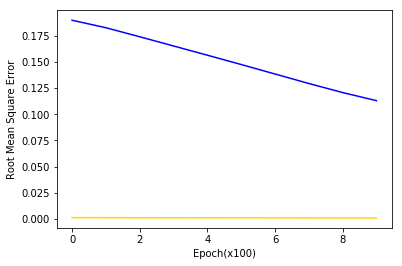

In [42]:
plt.figure(1)
plt.plot(train_error_summary, 'gold')
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x100)')
plt.ylabel('Root Mean Square Error')

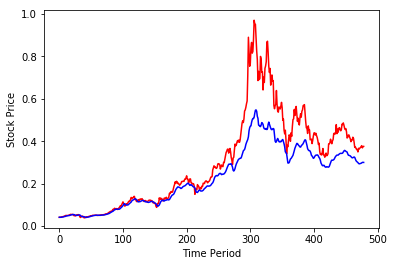

In [43]:
plt.figure(2)
plt.plot(testY, 'r')
plt.plot(test_predict, 'b')
plt.xlabel('Time Period')
plt.ylabel('Stock Price')
plt.show()

In [44]:
recent_data = np.array([x[len(x)-seq_length : ]])
print("recent_data.shape:", recent_data.shape)
print("recent_data:", recent_data)

recent_data.shape: (1, 28, 5)
recent_data: [[[0.45961866 0.46313717 0.44528753 0.44545924 0.28961448]
  [0.44591211 0.44591211 0.41285072 0.41521196 0.35597144]
  [0.41520945 0.42642672 0.4042673  0.41839509 0.28603533]
  [0.41892728 0.43188374 0.41288385 0.42939296 0.24597331]
  [0.42884872 0.43728452 0.41152073 0.42903398 0.30880439]
  [0.42845158 0.43502871 0.41596306 0.41867073 0.281183  ]
  [0.41837099 0.41857282 0.40185686 0.41156391 0.28346968]
  [0.41162516 0.4154153  0.39576322 0.39778155 0.2458118 ]
  [0.39765653 0.40680879 0.3917818  0.40564649 0.24168647]
  [0.40588548 0.41172608 0.40225149 0.40545621 0.19756413]
  [0.40544667 0.421283   0.40335052 0.41881482 0.2176438 ]
  [0.4192707  0.42103749 0.41137764 0.4140823  0.21613068]
  [0.41412648 0.41429618 0.39327596 0.39514367 0.21537642]
  [0.39490769 0.39579033 0.36833808 0.37084542 0.272181  ]
  [0.37101111 0.37992187 0.35946447 0.37232754 0.2536434 ]
  [0.37257656 0.37593241 0.36255271 0.36694533 0.20408438]
  [0.36726365

In [45]:
test_predict = sess.run(hypothesis, feed_dict={X: recent_data})

In [47]:
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [49]:
print("test_predict", test_predict[0])
test_predict = reverse_min_max_scaling(index,test_predict)
print("Tomorrow's stock price", test_predict[0])

test_predict [0.30095255]
Tomorrow's stock price [6165.7295]
